# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd
from liesel.contrib import splines
from smoothcon import SmoothCon

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

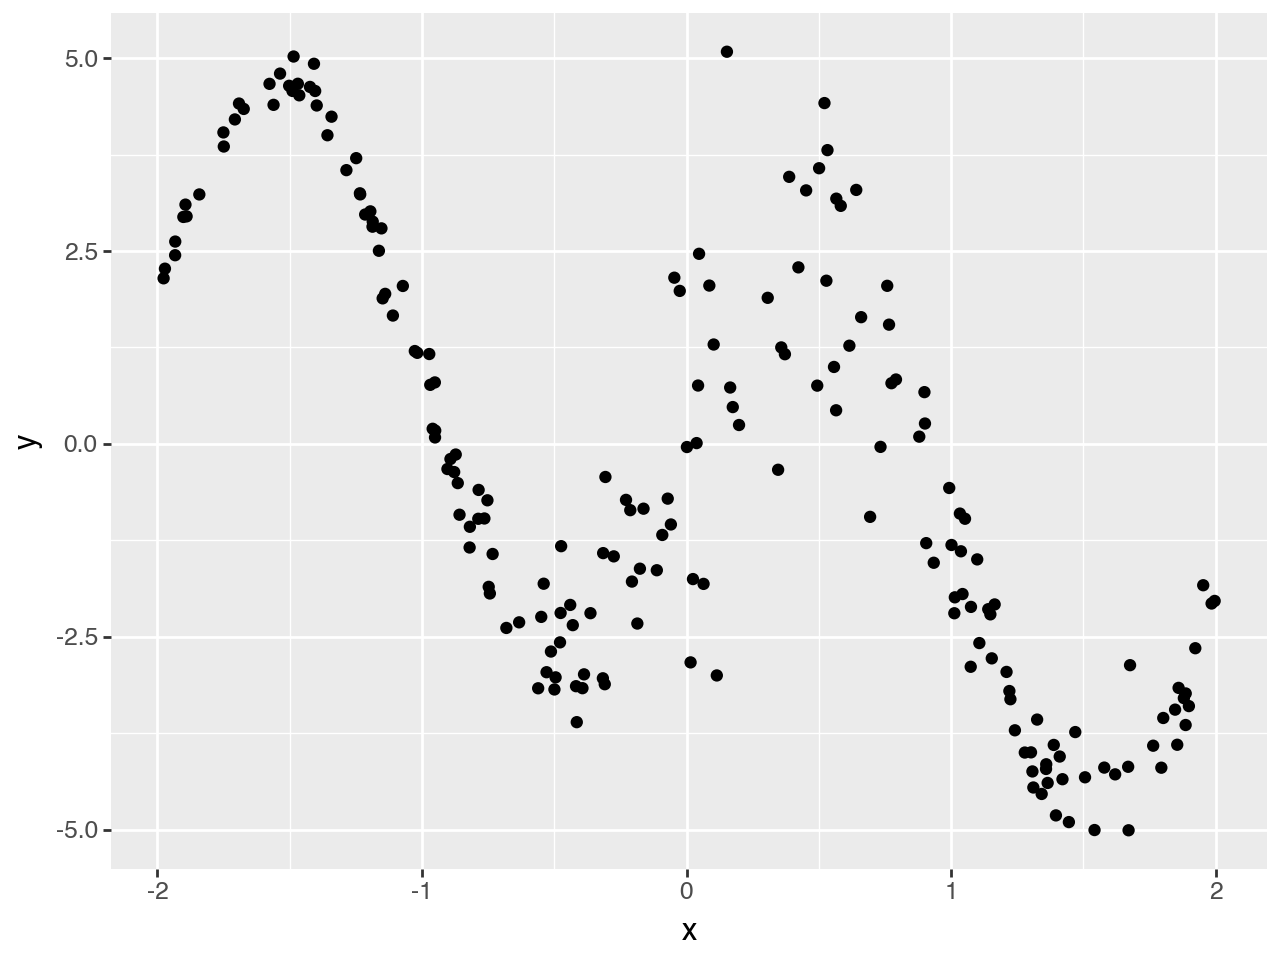

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [4]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Set up intercepts

In [ ]:
loc += gam.Intercept(name="$\\beta_0$", inference=gs.MCMCSpec(gs.IWLSKernel))
scale += gam.Intercept(name="$\\gamma_0$", inference=gs.MCMCSpec(gs.IWLSKernel))

### Set up basis an penalty matrices

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [5]:
smooth_x = SmoothCon(
    # this string is the R code you *would* call in mgcv for this term
    spec="s(x, bs='ps', k=20, m=c(3,2))",
    data=df,
)

x_basis = gam.Basis(smooth_x.basis, name="B(x)")
penalty = smooth_x.penalty

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [6]:

loc += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(x)",
    variance_name="$\\tau^2_m$",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

scale += gam.SmoothTerm.new_ig(
    basis=x_basis,
    penalty=penalty,
    ig_concentration=0.01,
    ig_scale=0.01,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(x)",
    variance_name="$\\tau^2_s$",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="B(x)_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


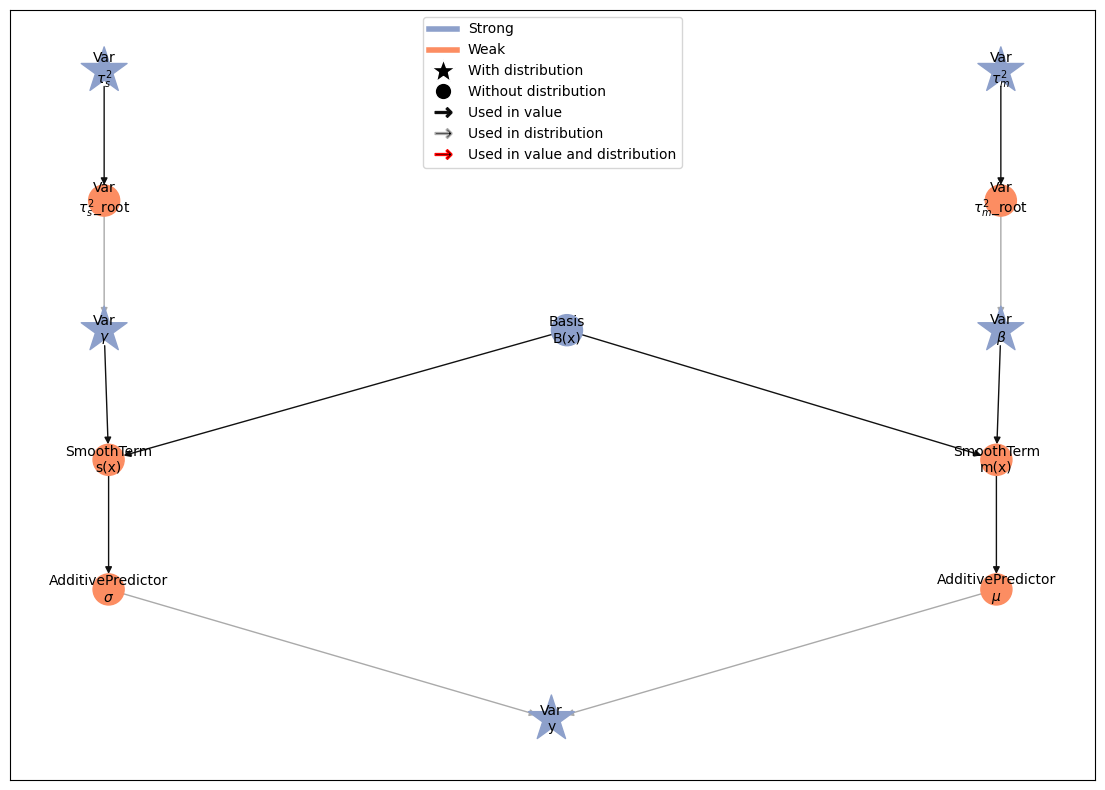

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\tau^2_s$', '$\\beta$', '$\\tau^2_m$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  5.50chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 143.35chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 144.35chunk/s]
liesel.goos

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                     kernel      mean        sd    q_0.05     q_0.5    q_0.95  \
parameter  index                                                                
$\beta$    (0,)   kernel_02  0.120220  0.507433 -0.711306  0.113466  0.988757   
           (1,)   kernel_02 -0.041597  0.480517 -0.836516 -0.032640  0.734111   
           (2,)   kernel_02  0.204315  0.476181 -0.536099  0.195006  0.997308   
           (3,)   kernel_02  0.087550  0.464332 -0.671492  0.084816  0.860439   
           (4,)   kernel_02  0.100006  0.447489 -0.621280  0.084745  0.853332   
           (5,)   kernel_02  0.121416  0.432747 -0.570860  0.115696  0.844680   
           (6,)   kernel_02 -0.054196  0.417947 -0.736493 -0.048565  0.607136   
           (7,)   kernel_02  0.074251  0.381374 -0.527899  0.067861  0.706909   
           (8,)   kernel_02 -0.053272  0.375132 -0.659284 -0.050435  0.566944   
           (9,)   kernel_02  0.046676  0.340686 -0.492521  0.040096  0.615862   
           (10,)  kernel_02  0.127855  0.317038 -0.428804  0.137253  0.633941   
           (11,)  kernel_02 -0.145572  0.281765 -0.606016 -0.144382  0.304361   
           (12,)  kernel_02  0.470935  0.243980  0.070766  0.469613  0.869073   
           (13,)  kernel_02 -0.172963  0.198902 -0.490942 -0.171006  0.146932   
           (14,)  kernel_02  1.354893  0.153085  1.122631  1.351897  1.611523   
           (15,)  kernel_02 -0.088248  0.100703 -0.253517 -0.086783  0.073942   
           (16,)  kernel_02  0.088067  0.057347 -0.004979  0.087549  0.180474   
           (17,)  kernel_02 -0.004092  0.024144 -0.042745 -0.004200  0.035929   
           (18,)  kernel_02 -0.327990  0.089485 -0.468236 -0.329377 -0.182071   
$\gamma$   (0,)   kernel_00  0.004386  0.126796 -0.194989  0.002799  0.210094   
           (1,)   kernel_00  0.004535  0.123531 -0.192128  0.005143  0.206132   
           (2,)   kernel_00  0.003386  0.124481 -0.197184  0.003977  0.199552   
           (3,)   kernel_00 -0.000369  0.121948 -0.199062  0.000327  0.198157   
           (4,)   kernel_00 -0.012098  0.126110 -0.213578 -0.011482  0.188584   
           (5,)   kernel_00  0.005320  0.122866 -0.192864  0.006207  0.201797   
           (6,)   kernel_00 -0.017568  0.122928 -0.218933 -0.014789  0.171481   
           (7,)   kernel_00  0.022173  0.120983 -0.169564  0.020375  0.220133   
           (8,)   kernel_00  0.014564  0.116665 -0.172287  0.013288  0.203749   
           (9,)   kernel_00 -0.001974  0.115955 -0.191744 -0.000835  0.190063   
           (10,)  kernel_00 -0.004490  0.106470 -0.173252 -0.005917  0.164595   
           (11,)  kernel_00 -0.006628  0.104834 -0.176904 -0.006536  0.165470   
           (12,)  kernel_00  0.068031  0.101374 -0.089231  0.063270  0.244621   
           (13,)  kernel_00 -0.074143  0.091747 -0.226830 -0.071781  0.071827   
           (14,)  kernel_00  0.051828  0.078403 -0.073698  0.049465  0.182253   
           (15,)  kernel_00 -0.106319  0.059270 -0.205946 -0.105140 -0.010872   
           (16,)  kernel_00 -0.007026  0.037141 -0.066132 -0.007686  0.053378   
           (17,)  kernel_00 -0.037679  0.016216 -0.063525 -0.038541 -0.010015   
           (18,)  kernel_00  0.134524  0.064866  0.029907  0.134144  0.241092   
$\tau^2_m$ ()     kernel_03  0.280656  0.149962  0.122341  0.247476  0.540020   
$\tau^2_s$ ()     kernel_01  0.015438  0.012962  0.004228  0.011912  0.038452   

                  sample_size     ess_bulk     ess_tail      rhat  
parameter  index                                                   
$\beta$    (0,)          4000  3596.587215  3389.417584  0.999976  
           (1,)          4000  3547.164506  3722.725712  1.000131  
           (2,)          4000  3209.051538  3666.532783  1.000195  
           (3,)          4000  3370.380075  3742.544247  1.000810  
           (4,)          4000  3556.780009  3788.608679  0.999711  
           (5,)          4000  3461.118721  3507.747267  1.000196  
           (6,)          4000  34

### MCMC trace plots

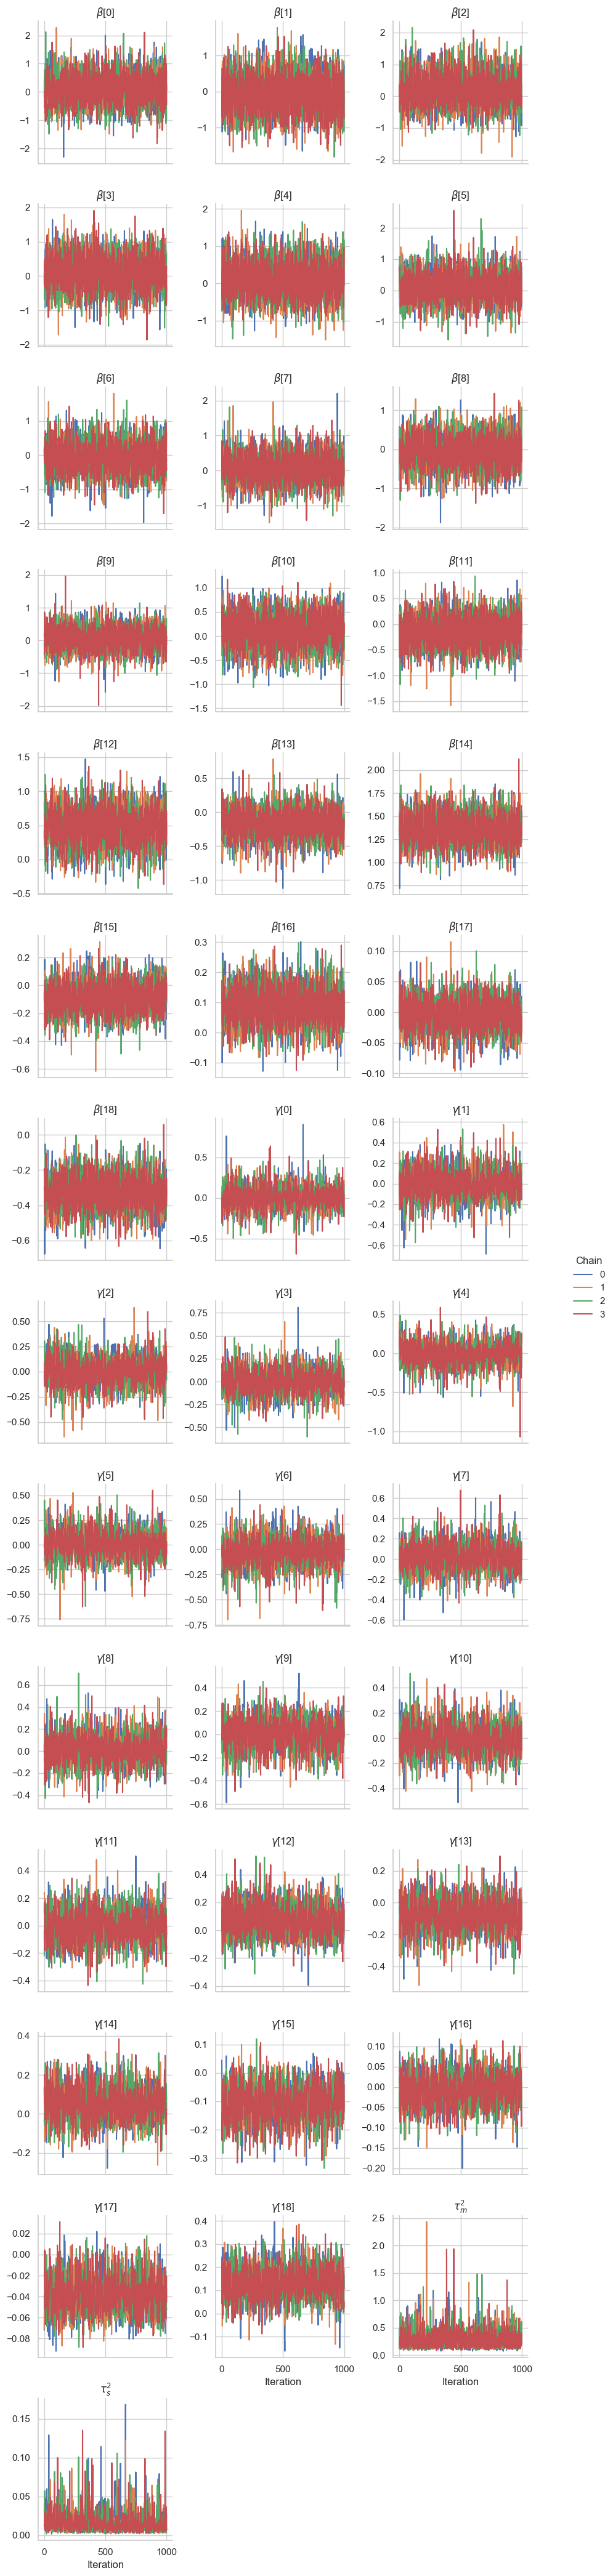

In [10]:
gs.plot_trace(results)

## Predictions

In [11]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

In [12]:
x_grid = jnp.linspace(x.min(), x.max(), 200)
B_x_grid = smooth_x.predict(data={"x": x_grid})

### Predict variables at new x values

In [13]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "s(x)", "$\\mu$", "$\\sigma$"],
    newdata={"B(x)": B_x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [14]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.212969,0.024615,0.156893,1.000279,3313.151741,2590.048195,0.002785,0.005578,1.983386,2.205989,2.463446,1.945590,2.417993,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.393474,0.017073,0.130664,1.000378,3299.125809,2647.790003,0.002364,0.005288,2.206315,2.388656,2.593187,2.201679,2.585021,-1.956738
2,$\mu$,$\mu$[2],"(2,)",4000,2.570551,0.012751,0.112922,1.000652,3249.870503,2761.135236,0.002087,0.004926,2.411717,2.566162,2.740239,2.408963,2.736565,-1.936774
3,$\mu$,$\mu$[3],"(3,)",4000,2.743836,0.010687,0.103379,1.000867,3276.876091,2681.716101,0.001930,0.004456,2.596001,2.739632,2.903905,2.595108,2.901531,-1.916810
4,$\mu$,$\mu$[4],"(4,)",4000,2.912939,0.010082,0.100410,1.000964,3262.329032,2639.114291,0.001861,0.003961,2.765771,2.909250,3.073068,2.758833,3.062515,-1.896846


### Plot fitted functions

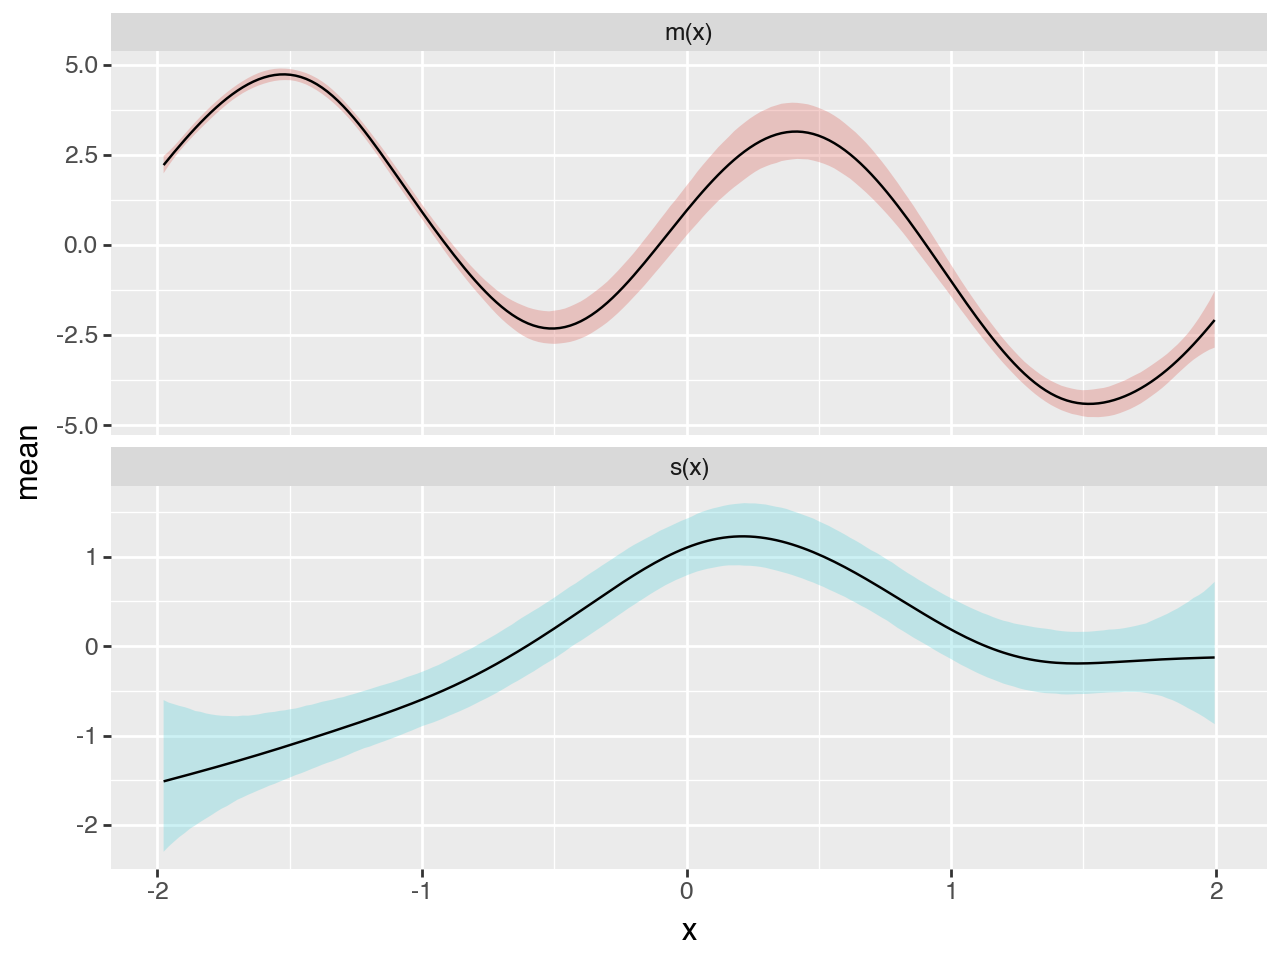

In [15]:
select = predictions_summary["variable"].isin(["s(x)", "m(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

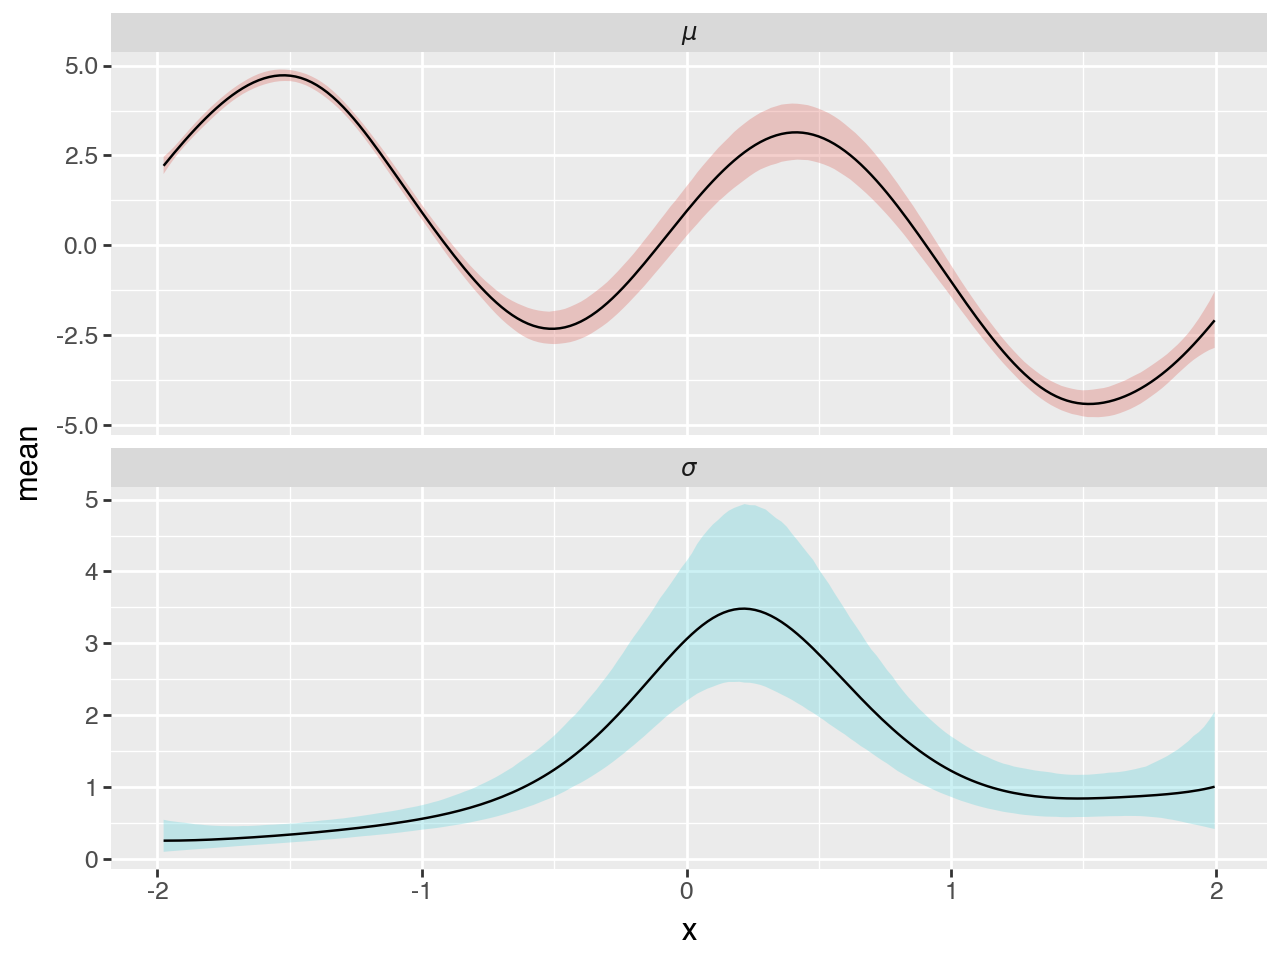

In [16]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

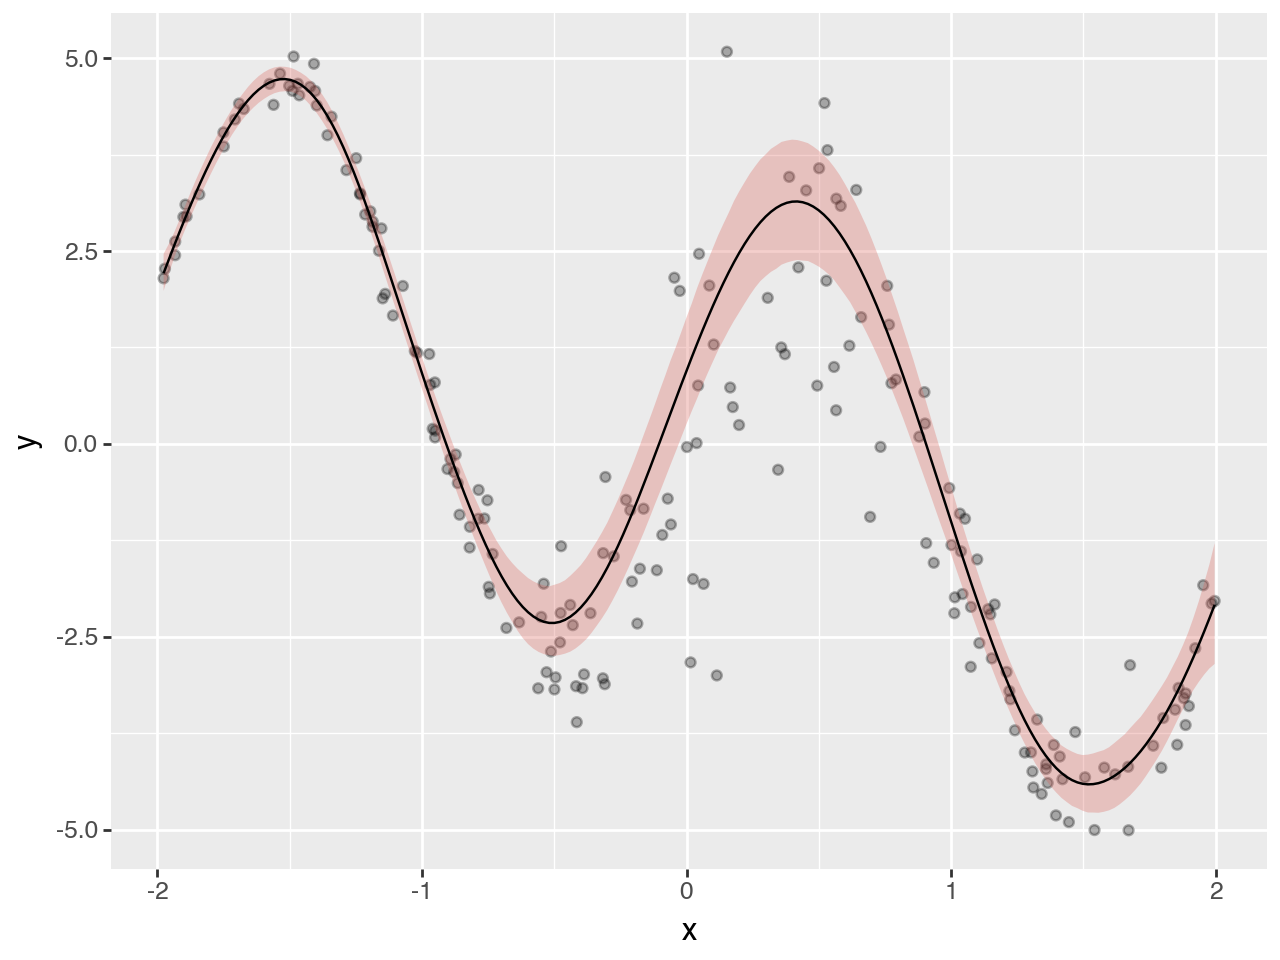

In [17]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [18]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.212969,0.255478,1.957490,2.468447
1,-1.956738,2.393474,0.255572,2.137902,2.649046
2,-1.936774,2.570551,0.256133,2.314418,2.826684
3,-1.916810,2.743836,0.257124,2.486712,3.000960
4,-1.896846,2.912939,0.258514,2.654425,3.171453
...,...,...,...,...,...
195,1.916248,-2.761439,0.946133,-3.707572,-1.815306
196,1.936212,-2.600774,0.958388,-3.559161,-1.642386
197,1.956176,-2.434232,0.972258,-3.406491,-1.461974
198,1.976140,-2.262222,0.988002,-3.250223,-1.274220


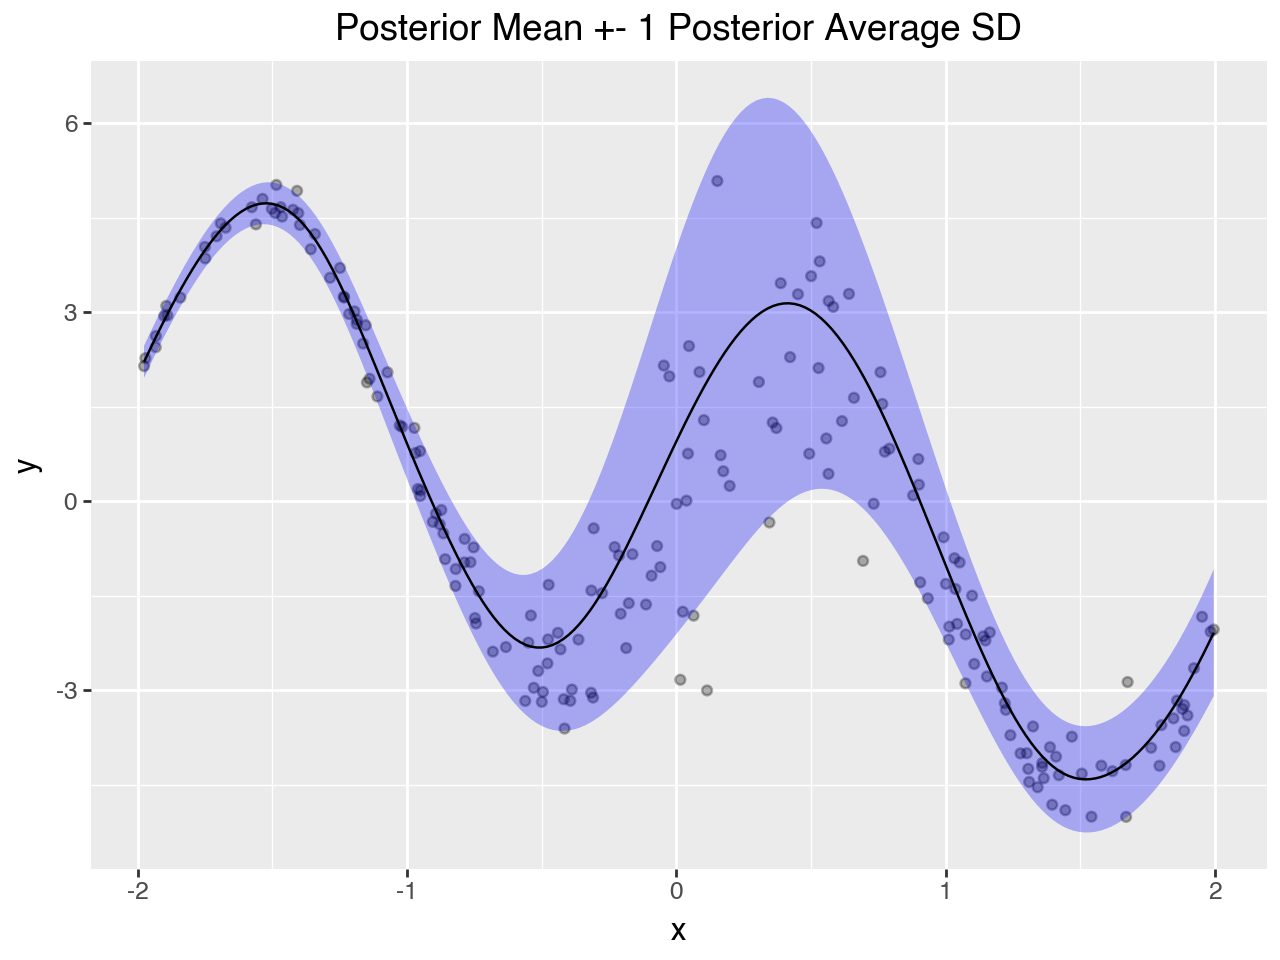

In [19]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [20]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [21]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [22]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

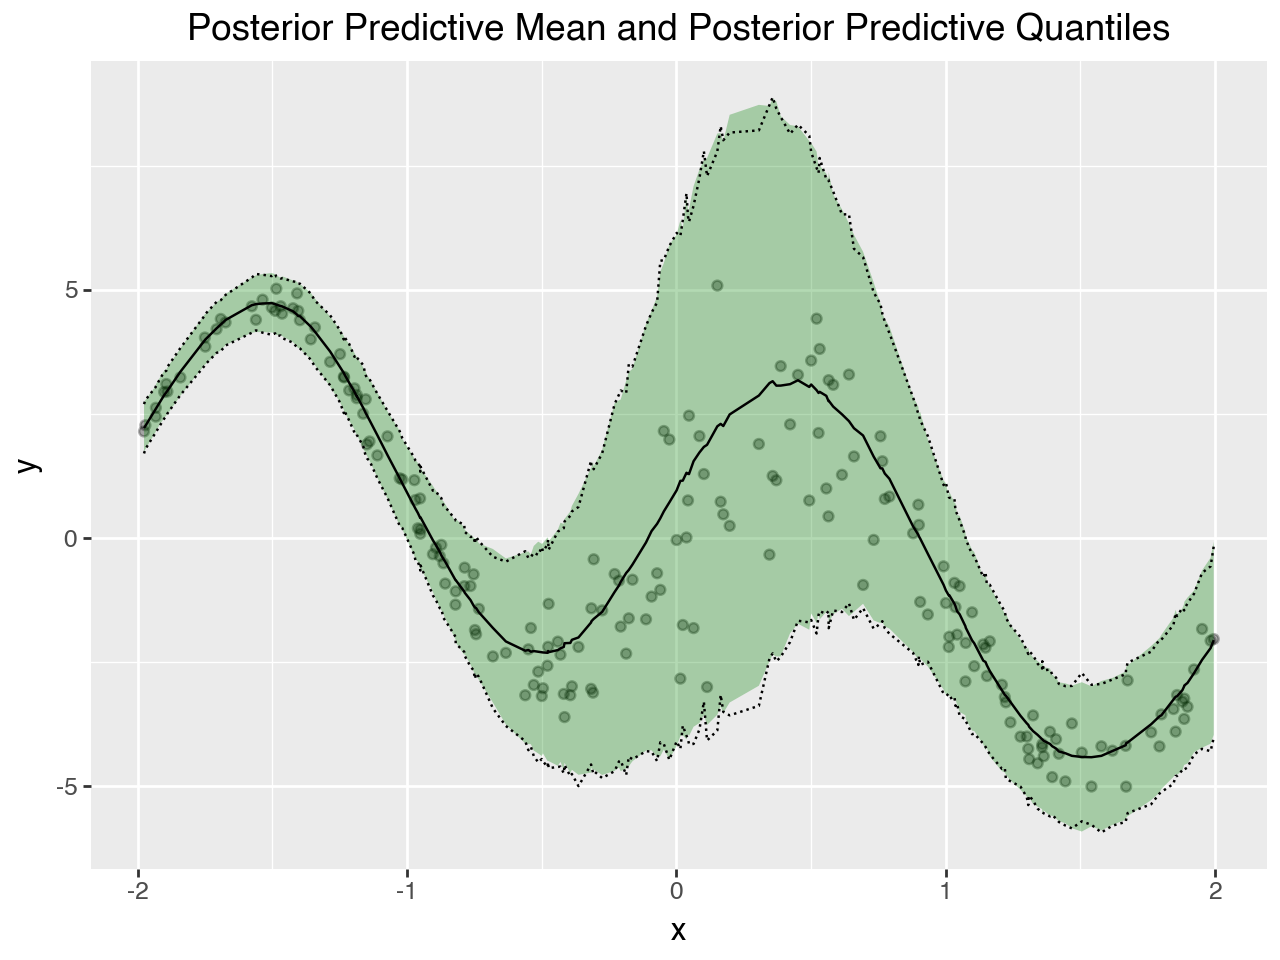

In [23]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

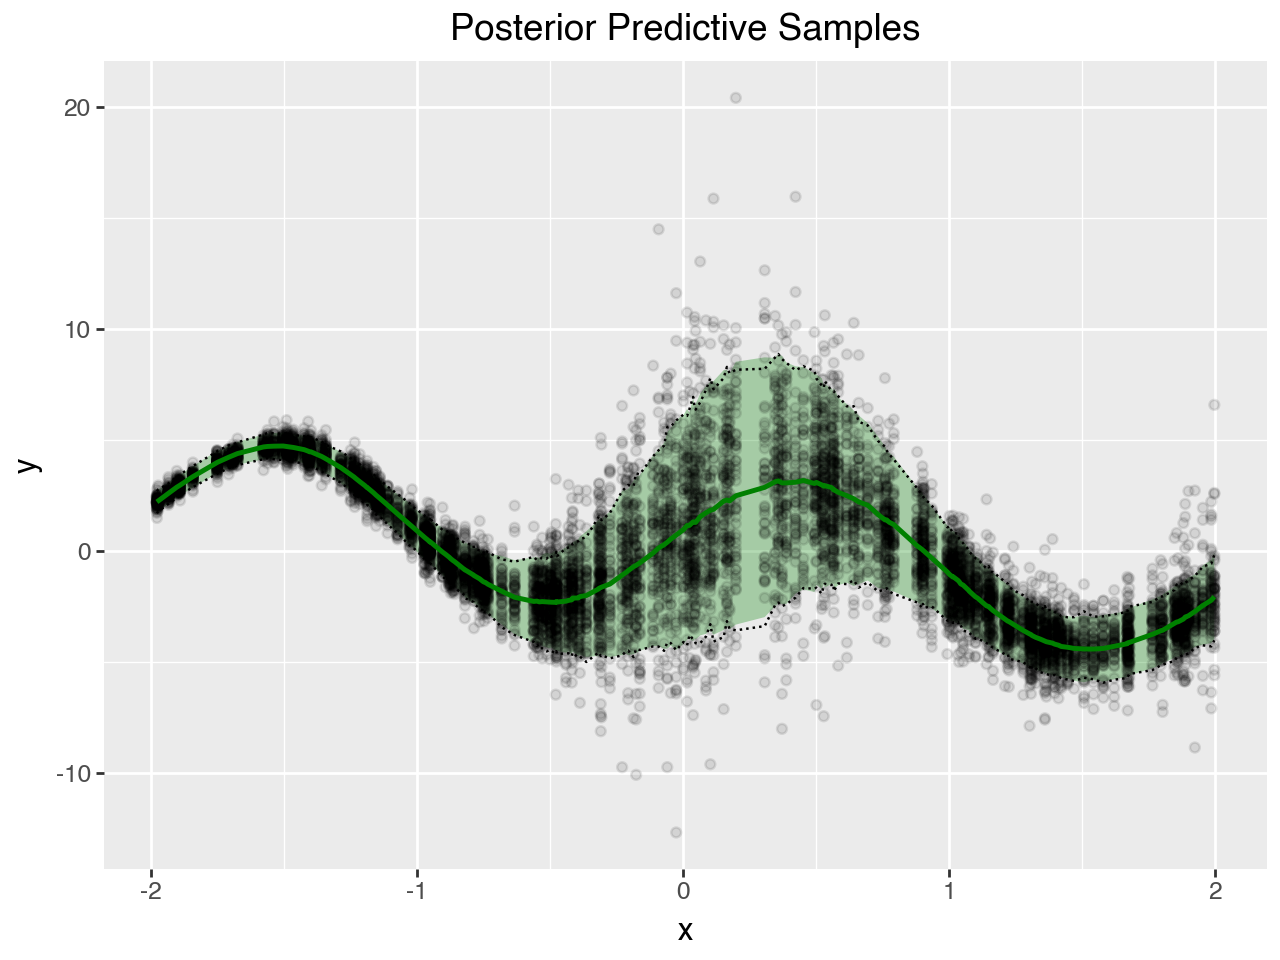

In [24]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)